# **IFN712 HAMA OBJECT CLASSIFICATION**

**Date: 31/10/2022**

**Train with HamaDataset_9327_images**

**Van Vu KIEU**

In [ ]:
import os
import cv2                          # for image loading and colour conversion
import glob
import math
import numpy as np      
from PIL import Image            # for reshaping, array manipulation
import matplotlib.pyplot as plt     # for plotting
import keras
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, load_img, img_to_array
from keras import layers
# tensorflow
import tensorflow as tf  
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.applications import MobileNetV2
# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Global variables**

In [ ]:
# default image size and shape
IMAGE_SIZE = (180, 180)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
# path to the folder contains the hama dataset
PATH_TO_DATASET = "/content/drive/MyDrive/IFN712_project/Hama_classification/HamaDataset_9372_images"

In [ ]:
PATH_TO_SAVE_MODEL =  "/content/drive/MyDrive/IFN712_project/Hama_classification/Trained_models"

In [ ]:
# number of types of hama objects
NUM_CLASSES = 13

# **1. Statistics of the dataset**

In [ ]:
def dataset_statistic(path_to_dataset):
  '''
  This function print out the statistic of the dataset, and display one sample image
  @param path_to_dataset: absolute path to the dataset
  
  '''
  # extension of images
  ext = ('.jpg', '.png')
  # A dictionary of sample images
  sample_images = {}
  # total images and classes
  total_image = 0
  classes = 0
  # iterate through the dataset
  for folder in os.listdir(path_to_dataset):
      classes += 1
      # absolute file name
      file_name = ""
      # number of images in this class
      num_img = 0
      # absolute directory name
      sub_dir = os.path.join(path_to_dataset, folder)
      # count the number of images in this folder
      for file in os.listdir(sub_dir):
          if file.endswith(ext):
              if file_name == "":
                  file_name = os.path.join(sub_dir, file)
                  sample_images[folder] = Image.open(file_name)
              num_img += 1
          else:
              continue
      print(f"Class {folder}: {num_img} images.")
      total_image += num_img
  print(f"There are total {total_image} images and {classes} classes in this dataset.")
  # display the example image
  # prepare to plot
  fig = plt.figure(figsize=(10, 10))
  # number of rows and columns in this plot
  columns = 2
  if len(sample_images) % columns:
      rows = len(sample_images) / columns + 1
  else:
      rows = len(sample_images) / columns
  i = 1
  # plot all sample images
  for object_name, img in sample_images.items():
      ax = fig.add_subplot(rows, columns, i)
      ax.imshow(img)
      ax.set_title(object_name)
      ax.axis('off')
      i += 1
  plt.show()
   


DATASET STATISTIC:

Class Hama_Fish: 688 images.
Class Hama_Shushi_1: 753 images.
Class Hama_Red_Duck: 666 images.
Class Hama_Shushi_2: 705 images.
Class Hama_Smile: 654 images.
Class Hama_Panda: 756 images.
Class Hama_Apple: 766 images.
Class Hama_Pink_House: 717 images.
Class Hama_Blue_Duck: 722 images.
Class Hama_Bear: 620 images.
Class Hama_Strawberry: 917 images.
Class Hama_Yellow_Duck: 728 images.
Class Hama_Sunglasses: 680 images.
There are total 9372 images and 13 classes in this dataset.


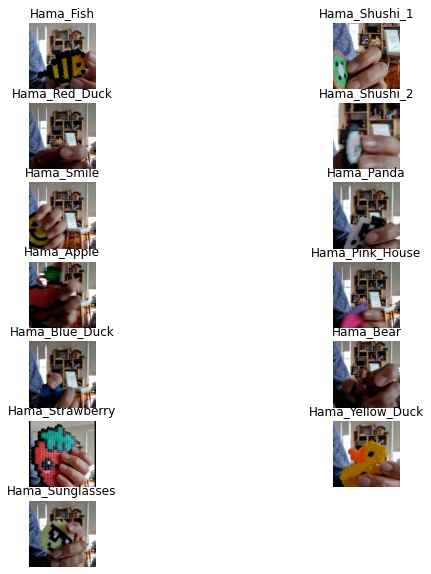

In [ ]:
print("\nDATASET STATISTIC:\n")
dataset_statistic(PATH_TO_DATASET)

# **2. Prepare training, validation and test set**

In [ ]:
# Prepare image ready for prediction or training
def prepare_image(file_name, target_size):    
    '''
    This function uses keras.preprocessing to load an image from a directory,
    then convert it into numpy array.
    @param file_name: absolute name of an image file
    @param target_size: target image size
    @return:  an array, which is scaled to [-1, 1], represents an image.
    '''
    # print(file_name)   
    # using keras's preprocessing image to load, resize and convert an image to an array
    img = load_img(file_name, target_size=target_size) 
    img_array = img_to_array(img)     
    return img_array


In [ ]:

def load_dataset(path_to_dataset, target_size):
  '''
  This function gets images from the dataset, prepares images for training
  @param path_to_dataset:
  @param target_size: target image size
  @return: image data, classes in integer format, classes in string format
  '''
  # extension of images
  ext = ('.jpg','.png')
  # list of image data in numpy array format
  X = []
  # list of classes in integer format
  Y = []
  # list of classes with string format
  classes = []
  # iterate through subfolders in the dataset
  i = 0
  for subfolder in os.listdir(path_to_dataset):
    # add this subfolder, which is the class name, into classes list
    classes.append(subfolder)
    # absolute directory name
    sub_dir = os.path.join(path_to_dataset, subfolder)
    # print(sub_dir)
    # iterate through the subfolder to process  every images          
    for file in os.listdir(sub_dir):
        if file.endswith(ext):
          file_name = os.path.join(sub_dir, file)   
          # print(file_name)     
          # preprocess the image and add it to image data list
          X.append(prepare_image(file_name, target_size))
          # add an integer value to the list
          Y.append(i)
        else:
          continue
    i +=1  
  return np.array(X), np.array(Y), classes




**70% training, 15% for validation, 15% for testing**

References: 

https://www.v7labs.com/blog/train-validation-test-set

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
def tran_val_test_gen(data, classes, val_size=0.15, test_size=0.15, shuffle = True, random_state = 42):
  '''
  This function generates the training, validation and test sets 
  @param data: image data 
  @param classes: classes of image 
  @param val_size: the ratio of validation dataset
  @param test_size: the ratio of test dataset
  @param shuffle: shuffle the dataset
  @param random_state: 42

  @return: train, valiation, and test set
  '''
  # ratio of dataset for assessment the model
  assess_size = val_size + test_size
  # keep assess_size for assessment
  X_train, X_assess, Y_train, Y_assess = train_test_split(data, classes, test_size = assess_size, random_state = random_state, shuffle = shuffle) 
  # generate dataset for every validation and test sets
  test_ratio = test_size/assess_size
  X_val, X_test, Y_val, Y_test = train_test_split(X_assess, Y_assess, test_size = test_ratio, random_state = random_state, shuffle = shuffle) 
  return X_train, Y_train, X_val, Y_val, X_test, Y_test


**Generating dataset function**

In [ ]:

# load, preprocess images from the dataset
X, Y, classes = load_dataset(PATH_TO_DATASET, IMAGE_SIZE)
# generate training, validation and test sets
X_train, Y_train, X_val, Y_val, X_test, Y_test = tran_val_test_gen(X, Y)  
# display some statistic
print(f"There are {len(classes)} classes, and {len(X)} images in this dataset.")
print(f"{len(X_train)} for training.")
print(f"{len(X_val)} for validation.")
print(f"{len(X_test)} for testing.")

There are 13 classes, and 9372 images in this dataset.
6560 for training.
1406 for validation.
1406 for testing.


# **3. Compile and train the model**

Reference: https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy


In [ ]:
num_classes = NUM_CLASSES
image_size = IMAGE_SIZE

In [ ]:
# data agumentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        # layers.RandomContrast(0.2),
        # layers.RandomZoom(0.2)        
    ]
)

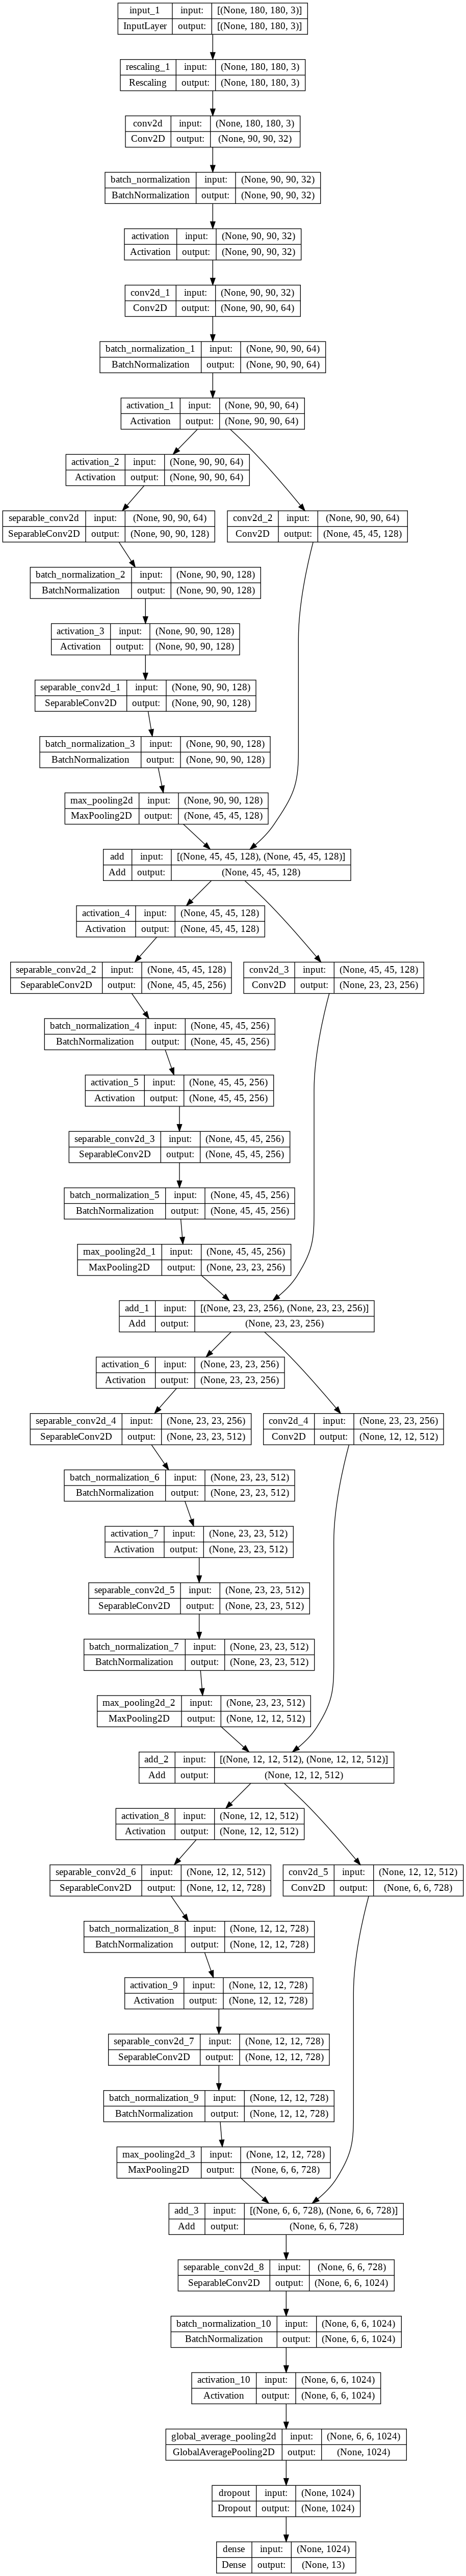

In [ ]:
# construct the model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# set up the parameters for compile the model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = keras.metrics.SparseCategoricalAccuracy()
# compile the model
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# set up parameters for train the model
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
batch_size = 32  # **************************
epochs = 50  # *****************************
# train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                      batch_size = batch_size, epochs = epochs, verbose=1, callbacks=[es])
# save the trained model
model.save(os.path.join(PATH_TO_SAVE_MODEL,'imageclassifier_third_trained_with_HamaDataset_9372_images_retrain.h5'))

Epoch 1/50
205/205 [==============================] - 63s 251ms/step - loss: 0.3676 - sparse_categorical_accuracy: 0.8864 - val_loss: 2.9515 - val_sparse_categorical_accuracy: 0.0690
Epoch 2/50
205/205 [==============================] - 56s 275ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9738 - val_loss: 3.4664 - val_sparse_categorical_accuracy: 0.1067
Epoch 3/50
205/205 [==============================] - 57s 278ms/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.6074 - val_sparse_categorical_accuracy: 0.8016
Epoch 4/50
205/205 [==============================] - 57s 277ms/step - loss: 0.0247 - sparse_categorical_accuracy: 0.9939 - val_loss: 2.6615 - val_sparse_categorical_accuracy: 0.6110
Epoch 5/50
205/205 [==============================] - 57s 276ms/step - loss: 0.0678 - sparse_categorical_accuracy: 0.9806 - val_loss: 2.8554 - val_sparse_categorical_accuracy: 0.6821
Epoch 6/50
205/205 [==============================] - 58s 281ms/step - loss: 0.0225 -

**Plotting**

https://neptune.ai/blog/keras-metrics

In [ ]:
# plot errors
def plot_errors(history):
  '''
  This function plots the training and validation errors  
  @param history: the history of fitting the model
  '''
  fig = plt.figure(figsize=[6, 6])  
  # a figure with a single Axes
  ax = fig.add_subplot()
  ax.plot(history['loss'], label='Train Error')
  ax.plot(history['val_loss'], label='Validation Error')  
  ax.set_ylabel("errors")
  ax.set_xlabel("epochs")
  ax.legend()
  ax.set_title(f'Errors of the model')

In [ ]:
# plot accuracies
def plot_accuracies(history):
    """
    This function plots the training and validation accuracies
    @param history: the history of fitting the model
    """
    fig = plt.figure(figsize=[6, 6])
    # a figure with a single Axes
    ax = fig.add_subplot()
    ax.plot(history['sparse_categorical_accuracy'], label='Train Accuracy')
    ax.plot(history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    ax.set_ylabel("accuracies")
    ax.set_xlabel("epochs")
    ax.legend()
    ax.set_title(f'Accuracies of the model')

In [ ]:
def evaluate_model(model, history, X_test, Y_test):
    """
    this function evaluate the model by using the test set
    @param model: the classification model
    @param history: the history of fitting the model
    @param X_test: test data
    @param Y_test: test classes
    """
    # predict the test set, return top five largest values
    # predictions is a list of lists with five elements
    predictions = model.predict(X_test)
    # get the index of the largest value for every classes
    indexes = tf.argmax(predictions, axis=1)

    conf_matrix = confusion_matrix(Y_test, indexes)
    acc_score = accuracy_score(Y_test, indexes, normalize=True)
    f1_sc = f1_score(Y_test, indexes, average='macro')
    print(f"\nResults of prediction on the test set,"
          f"\nAccuracy: {acc_score}\nMean f1-score: {f1_sc}")

    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_subplot()
    conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(len(np.unique(Y_test))))
    conf_matrix_disp.plot(ax=ax)
    ax.set_title(f'Confusion matrix')

    print(f"\nClassification report:")
    print(classification_report(Y_test, indexes))



**Plotting the validation**

44/44 [==============================] - 2s 47ms/step

Results of prediction on the test set,
Accuracy: 0.9985775248933144
Mean f1-score: 0.9985363116182673

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       0.99      1.00      1.00       113
           2       1.00      1.00      1.00        89
           3       0.99      1.00      0.99        93
           4       1.00      0.99      0.99        95
           5       1.00      0.99      1.00       126
           6       1.00      1.00      1.00       125
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       112
           9       1.00      1.00      1.00        84
          10       1.00      1.00      1.00       136
          11       1.00      1.00      1.00       106
          12       1.00      1.00      1.00       117

    accuracy                           1.00      1406
   macr

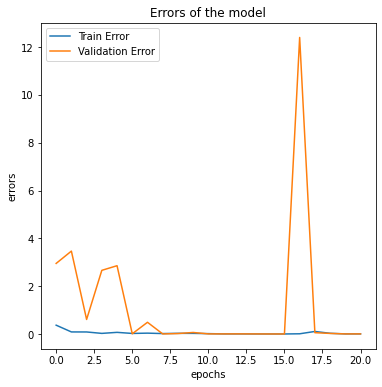

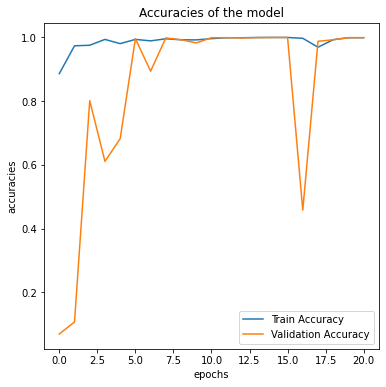

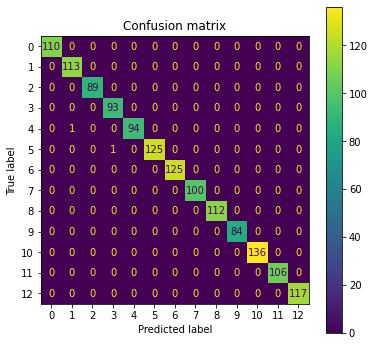

In [ ]:
# plot the errors
plot_errors(history.history)
# plot the accuracies
plot_accuracies(history.history)
# evaluate the model
evaluate_model(model, history, X_test, Y_test)

# show the plots
plt.show()

# **6. Test the trained model with a new image**

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
classes

['Hama_Fish',
 'Hama_Shushi_1',
 'Hama_Red_Duck',
 'Hama_Shushi_2',
 'Hama_Smile',
 'Hama_Panda',
 'Hama_Apple',
 'Hama_Pink_House',
 'Hama_Blue_Duck',
 'Hama_Bear',
 'Hama_Strawberry',
 'Hama_Yellow_Duck',
 'Hama_Sunglasses']

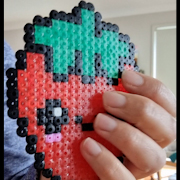

1/1 [==============================] - 0s 388ms/step
[[4.4984658e-11 1.3024939e-10 2.0824317e-14 1.6345500e-07 1.3335207e-15
  1.5218767e-12 1.0541492e-08 1.8315177e-10 3.1143265e-15 1.6231563e-12
  9.9999988e-01 3.5407357e-17 1.4549471e-11]]
tf.Tensor(
[0.06794272 0.06794272 0.06794272 0.06794272 0.06794272 0.06794272
 0.06794272 0.06794272 0.06794272 0.06794272 0.18468742 0.06794272
 0.06794272], shape=(13,), dtype=float32)
This image most likely belongs to Hama_Strawberry with a 18.47 percent confidence.


In [ ]:
img_path = "/content/drive/MyDrive/IFN712_project/Hama_classification/Hama_Test_images/Hama_Strawberry026.jpg"

#display the image
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

# read image to predict
img_array = prepare_image(img_path, IMAGE_SIZE)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])
print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)